# Importing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# !pip install preprocessor
# !pip install bert-tensorflow
# !pip install simpletransformers

# !pip3 uninstall apex
# !git clone https://www.github.com/nvidia/apex
# ! cd /content/apex
# ! python3 '/content/apex/setup.py' install

!pip3 install -q ktrain
!pip3 install -q tensorflow_gpu==2.1.0
!pip install emoji

# ! pip install -q transformers

In [ ]:
import pandas as pd
import numpy as np
import nltk
import random
# import preprocessor as p
from sklearn.model_selection import train_test_split
import sklearn
# from simpletransformers.classification import MultiLabelClassificationModel
import ktrain
from ktrain import text as txt
# import emoji  # https://pypi.org/project/emoji/
from tqdm.auto import tqdm
tqdm.pandas()

from pathlib import Path 

import os

import torch
import torch.optim as optim

import random 

# fastai
from fastai import *
from fastai.text import *
from fastai.callbacks import *

# transformers
from transformers import PreTrainedModel, PreTrainedTokenizer, PretrainedConfig

from transformers import BertForSequenceClassification, BertTokenizer, BertConfig
from transformers import RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig
from transformers import XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig
from transformers import XLMForSequenceClassification, XLMTokenizer, XLMConfig
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig

In [ ]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', 100)

# Data

In [ ]:
path = '/content/drive/My Drive/COLAB NOTEBOOKS/SCL/C06'
train = pd.read_csv(path+'/train.csv')
test = pd.read_csv(path+'/test.csv')

In [ ]:
train.shape

## Leaks

In [ ]:
ratio = train.rating.value_counts(normalize=True)
ans = [1]*int(round(len(test)*ratio[1]))+[2]*int(round(len(test)*ratio[2]))+[3]*int(round(len(test)*ratio[3]))+[4]*int(round(len(test)*ratio[4]))+[5]*int(round(len(test)*ratio[5]))
len(ans)
test['rating'] = ans
test[['review_id','rating']].to_csv('submission.csv',index=False)

# Legit

In [ ]:
train['rating'] = train['rating'].astype('str')
# product = train.pivot(index='review_id',columns='rating',values='review')
one_hot = pd.get_dummies(train['rating'])
# Drop column B as it is now encoded
train = train.drop('rating',axis = 1)
# Join the encoded df
train = train.join(one_hot)

In [ ]:
train.head()

,review_id,review,1,2,3,4,5
0,0,Ga disappointed neat products .. Meletot Hilsnyaa Speed ​​of delivery is good.,1,0,0,0,0
1,1,"Rdtanya replace broken glass, broken chargernya",1,0,0,0,0
2,2,Nyesel bngt dsni shopping antecedent photo message pictures gk according foto.di existing collag...,1,0,0,0,0
3,3,Sent a light blue suit goods ga want a refund,1,0,0,0,0
4,4,Pendants came with dents and scratches on its surface. The coating looks like it will change col...,1,0,0,0,0


# Preprocessing

In [ ]:
def simplify(df):
  """
  Format df into simpletransformers format
  """
  df['labels'] = list(zip(df['1'].tolist(),  df['2'].tolist(), df['3'].tolist(),  df['4'].tolist(), df['5'].tolist()))
  df['text'] = df['review'].apply(lambda x: x.replace('\n', ' '))

  df = df[['text','labels']]
  return df

In [ ]:
train = simplify(train)

In [ ]:
train_df, eval_df = train_test_split(train, test_size=0.2)

# Simple Transformers
## Roberta


In [ ]:
train_df.iloc[1240]

text      Excelleny quality.. ✔ Very accomodating seller.. ✔ Well-packaged.. ✔ Item shipped immediately.. ...
labels                                                                                        (0, 0, 0, 0, 1)
Name: 141186, dtype: object

In [ ]:
model = MultiLabelClassificationModel('roberta', 'roberta-base', num_labels=5, 
                                      args={'train_batch_size':2, 
                                            'gradient_accumulation_steps':16, 
                                            'learning_rate': 3e-4, 
                                            'num_train_epochs': 1, 
                                            'max_seq_length': 60, 
                                            'fp16':False, 
                                            'reprocess_input_data': True,
                                            'preprocess_inputs': True})

# model = MultiLabelClassificationModel('roberta', 'roberta-base', num_labels=5, 
#                                       args={'num_train_epochs': 1, 
#                                             'max_seq_length': 500, 
#                                             'fp16':False, 
#                                             'reprocess_input_data': True, 
#                                             'learning_rate': 3e-4,
#                                             'train_batch_size':2})

In [ ]:
model.train_model(train_df)

In [ ]:
eval_df = eval_df[['text','labels']]
result, model_outputs, wrong_predictions = model.eval_model(eval_df, acc=sklearn.metrics.accuracy_score)
print(result)
print(model_outputs)

In [ ]:
test['text'] = test['review'].apply(lambda x: x.replace('\n', ' '))
predictions, raw_outputs = model.predict(test['text'])
print(predictions)
print(raw_outputs)

# Ktrain


## Fasttext

In [ ]:
DATA_PATH = '/content/drive/My Drive/COLAB NOTEBOOKS/SCL/C06/train.csv'
NUM_WORDS = 50000
MAXLEN = 150
(x_train, y_train), (x_test, y_test), preproc =  txt.texts_from_csv(DATA_PATH,
                                'review',
                                 label_columns='rating',
                                 val_filepath=None, 
                                 max_features=NUM_WORDS, 
                                 maxlen=100,
                                 ngram_range=1,
                                 preprocess_mode='bert')

detected encoding: ISO-8859-1 (if wrong, set manually)
downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


Is Multi-Label? False
compiling word ID features...
maxlen is 150
done.
simulating training for different learning rates... this may take a few moments...
Train on 132129 samples
Epoch 1/1024
 59264/132129 [============>.................] - ETA: 1:25 - loss: 1.9344 - accuracy: 0.2371

done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


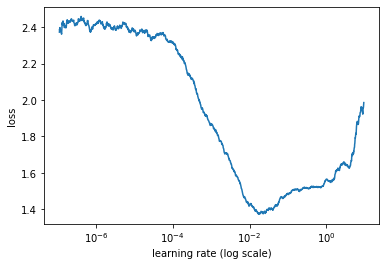

In [ ]:
# model = t.get_classifier()
model = txt.text_classifier('fasttext', (x_train, y_train), preproc=preproc)
# learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=6)
learner = ktrain.get_learner(model, train_data=(x_train, y_train),
                                   val_data=(x_test, y_test))
# find a good learning rate
learner.lr_find()
learner.lr_plot()

In [ ]:
learner.fit_onecycle(3e-4, 4)



begin training using onecycle policy with max lr of 0.0003...
Train on 132129 samples, validate on 14682 samples
Epoch 1/4
132129/132129 [==============================] - 160s 1ms/sample - loss: 1.7291 - accuracy: 0.2844 - val_loss: 1.2707 - val_accuracy: 0.4291
Epoch 2/4
132129/132129 [==============================] - 158s 1ms/sample - loss: 1.2600 - accuracy: 0.4125 - val_loss: 1.1181 - val_accuracy: 0.4661
Epoch 3/4
132129/132129 [==============================] - 159s 1ms/sample - loss: 1.1447 - accuracy: 0.4567 - val_loss: 1.0797 - val_accuracy: 0.4781
Epoch 4/4
132129/132129 [==============================] - 158s 1ms/sample - loss: 1.0956 - accuracy: 0.4781 - val_loss: 1.0717 - val_accuracy: 0.4806


In [ ]:
test.head()

,review_id,review
0,1,"Great danger, cool, motif and cantik2 jg models. Delivery cepet. Tp packing less okay krn only w..."
1,2,One of the shades don't fit well
2,3,Very comfortable
3,4,Fast delivery. Product expiry is on Dec 2022. Product wrap properly. No damage on the item.
4,5,it's sooooo cute! i like playing with the glitters better than browsing on my phone now. item wa...


In [ ]:
# predictor = ktrain.get_predictor(learner.model, preproc)
# predictor.save('/content/drive/My Drive/COLAB NOTEBOOKS/SCL/C06/first_predictor')
predictor = ktrain.load_predictor('/content/drive/My Drive/COLAB NOTEBOOKS/SCL/C06/first_predictor')

preds = test.review.progress_apply(lambda x: np.argmax(predictor.predict_proba(x)))

In [ ]:
final = pd.DataFrame({'review_id': test.review_id, 'rating': preds})
final.to_csv('/content/drive/My Drive/COLAB NOTEBOOKS/SCL/C06/dom_fasttext.csv', index=False)

## Bert

In [ ]:
DATA_PATH = '/content/drive/My Drive/COLAB NOTEBOOKS/SCL/C06/train.csv'
NUM_WORDS = 50000
MAXLEN = 150
(x_train, y_train), (x_test, y_test), preproc =  txt.texts_from_csv(DATA_PATH,
                                'review',
                                 label_columns='rating',
                                 val_filepath=None, 
                                 max_features=NUM_WORDS, 
                                 maxlen=100,
                                 ngram_range=1,
                                 preprocess_mode='bert')
# model = t.get_classifier()
model = txt.text_classifier('bert', (x_train, y_train), preproc=preproc)
# learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=6)
learner = ktrain.get_learner(model, train_data=(x_train, y_train),
                                   val_data=(x_test, y_test))
# # find a good learning rate
# learner.lr_find()
# learner.lr_plot()

detected encoding: ISO-8859-1 (if wrong, set manually)
preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


Is Multi-Label? False
maxlen is 100
done.


In [ ]:
learner.fit_onecycle(3e-4, 4)



begin training using onecycle policy with max lr of 0.0003...
Train on 132129 samples, validate on 14682 samples
Epoch 1/4
132129/132129 [==============================] - 6062s 46ms/sample - loss: 1.1002 - accuracy: 0.4715 - val_loss: 1.2152 - val_accuracy: 0.4334
Epoch 2/4
132129/132129 [==============================] - 6032s 46ms/sample - loss: 1.4715 - accuracy: 0.3024 - val_loss: 1.5219 - val_accuracy: 0.2795
Epoch 3/4
132129/132129 [==============================] - 5990s 45ms/sample - loss: 1.5164 - accuracy: 0.2794 - val_loss: 1.5149 - val_accuracy: 0.2795
Epoch 4/4
132129/132129 [==============================] - 6001s 45ms/sample - loss: 1.5071 - accuracy: 0.2834 - val_loss: 1.5014 - val_accuracy: 0.2899


In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc)
predictor.save('/content/drive/My Drive/COLAB NOTEBOOKS/SCL/C06/bert')

In [ ]:
predictor = ktrain.load_predictor('/content/drive/My Drive/COLAB NOTEBOOKS/SCL/C06/bert')
preds = test.review.progress_apply(lambda x: np.argmax(predictor.predict_proba(x)))

In [ ]:
final = pd.DataFrame({'review_id': test.review_id, 'rating': preds})
final.to_csv('/content/drive/My Drive/COLAB NOTEBOOKS/SCL/C06/dom_bert.csv', index=False)

In [ ]:
train.rating.value_counts(normalize=True)

4    0.285163
5    0.282779
3    0.244811
1    0.100708
2    0.086540
Name: rating, dtype: float64

In [ ]:
final.rating.value_counts(normalize=True)

5    0.359492
4    0.270723
3    0.226273
1    0.136065
2    0.007447
Name: rating, dtype: float64

# Extended Train Set

In [ ]:
test_labeled = pd.read_csv("/content/drive/My Drive/COLAB NOTEBOOKS/SCL/C06/31GB_submission.csv")
test_labeled = pd.merge(test, test_labeled, on='review_id')
new_train = train.append(test_labeled, ignore_index=True)
new_train.drop(columns='review_id', inplace=True)
new_train.to_csv('/content/drive/My Drive/COLAB NOTEBOOKS/SCL/C06/new_train.csv', index=False)
# train_df = pd.read_csv('/content/drive/My Drive/COLAB NOTEBOOKS/SCL/C06/new_train.csv')
train_df = pd.read_csv('/content/drive/My Drive/COLAB NOTEBOOKS/SCL/C06/train.csv')
test_df = pd.read_csv('/content/drive/My Drive/COLAB NOTEBOOKS/SCL/C06/test.csv')

In [ ]:
have_emoji_train_idx = []
have_emoji_test_idx = []

for idx, review in enumerate(train_df['review']):
    if any(char in emoji.UNICODE_EMOJI for char in review):
        have_emoji_train_idx.append(idx)
        
for idx, review in enumerate(test_df['review']):
    if any(char in emoji.UNICODE_EMOJI for char in review):
        have_emoji_test_idx.append(idx)

In [ ]:
train_emoji_percentage = round(len(have_emoji_train_idx) / train_df.shape[0] * 100, 2)
print(f'Train data has {len(have_emoji_train_idx)} rows that used emoji, that means {train_emoji_percentage} percent of the total')

test_emoji_percentage = round(len(have_emoji_test_idx) / test_df.shape[0] * 100, 2)
print(f'Test data has {len(have_emoji_test_idx)} rows that used emoji, that means {test_emoji_percentage} percent of the total')

Train data has 20048 rows that used emoji, that means 13.66 percent of the total
Test data has 0 rows that used emoji, that means 0.0 percent of the total


In [ ]:
print('Without demojize: ', train_df.loc[70266, 'review'])
print('\nUsing demojize: ', emoji.demojize(train_df.loc[70266, 'review']))

Without demojize:  Excellent, Satisfied, Good Packaging, Recommended & Nice... 😊😊😊😊 😎😎😎😎

Using demojize:  Excellent, Satisfied, Good Packaging, Recommended & Nice... :smiling_face_with_smiling_eyes::smiling_face_with_smiling_eyes::smiling_face_with_smiling_eyes::smiling_face_with_smiling_eyes: :smiling_face_with_sunglasses::smiling_face_with_sunglasses::smiling_face_with_sunglasses::smiling_face_with_sunglasses:


In [ ]:
def emoji_cleaning(text):
    
    # Change emoji to text
    text = emoji.demojize(text).replace(":", " ")
    
    # Delete repeated emoji
    tokenizer = text.split()
    repeated_list = []
    
    for word in tokenizer:
        if word not in repeated_list:
            repeated_list.append(word)
    
    text = ' '.join(text for text in repeated_list)
    text = text.replace("_", " ").replace("-", " ")
    return text

In [ ]:
train_df_original = train_df.copy()
test_df_original = test_df.copy()

# emoji_cleaning
train_df.loc[have_emoji_train_idx, 'review'] = train_df.loc[have_emoji_train_idx, 'review'].apply(emoji_cleaning)
test_df.loc[have_emoji_test_idx, 'review'] = test_df.loc[have_emoji_test_idx, 'review'].apply(emoji_cleaning)

In [ ]:
def review_cleaning(text):
    
    # delete lowercase and newline
    text = text.lower()
    text = re.sub(r'\n', '', text)
    
    # change emoticon to text
    text = re.sub(r':\(', 'dislike', text)
    text = re.sub(r': \(\(', 'dislike', text)
    text = re.sub(r':, \(', 'dislike', text)
    text = re.sub(r':\)', 'smile', text)
    text = re.sub(r';\)', 'smile', text)
    text = re.sub(r':\)\)\)', 'smile', text)
    text = re.sub(r':\)\)\)\)\)\)', 'smile', text)
    text = re.sub(r'=\)\)\)\)', 'smile', text)
    
    # delete punctuation
    text = re.sub('[^a-z0-9 ]', ' ', text)
    
    tokenizer = text.split()
    
    return ' '.join([text for text in tokenizer])

In [ ]:
import regex as re
train_df['review'] = train_df['review'].apply(review_cleaning)
test_df['review'] = test_df['review'].apply(review_cleaning)

In [ ]:
repeated_rows_train = []
repeated_rows_test = []

for idx, review in enumerate(train_df['review']):
    if re.match(r'\w*(\w)\1+', review):
        repeated_rows_train.append(idx)
        
for idx, review in enumerate(test_df['review']):
    if re.match(r'\w*(\w)\1+', review):
        repeated_rows_test.append(idx)

In [ ]:
print(f'Total {len(repeated_rows_train)} rows')

Total 43139 rows


In [ ]:
def delete_repeated_char(text):
    
    text = re.sub(r'(\w)\1{2,}', r'\1', text)
    
    return text

In [ ]:
train_df.loc[repeated_rows_train, 'review'] = train_df.loc[repeated_rows_train, 'review'].apply(delete_repeated_char)
test_df.loc[repeated_rows_test, 'review'] = test_df.loc[repeated_rows_test, 'review'].apply(delete_repeated_char)

In [ ]:
print('Before: ', train_df_original.loc[92129, 'review'])
print('After: ', train_df.loc[92129, 'review'])

print('\nBefore: ', train_df_original.loc[56938, 'review'])
print('After: ', train_df.loc[56938, 'review'])

print('\nBefore: ', train_df_original.loc[72677, 'review'])
print('After: ', train_df.loc[72677, 'review'])

print('\nBefore: ', train_df_original.loc[36558, 'review'])
print('After: ', train_df.loc[36558, 'review'])

Before:  Ttttthhhhhhhhheeeeeeee bbbbbbbeeeeesssttttttttt bbbbaaannngggettttttt
After:  the best banget

Before:  Mmmmmuuuuuuuuuurrrrrrraaaaaaahhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhh mmmeeeeerrrrrriiiiiiiiiiiiiaaaaahhhhhhhhh👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍 = ¢ ✓ € ✓ € ¢} = {¢ × `{{|}} {¢ ¢ ¢ = ¢ = {÷ € € € = {{ €€ {{
After:  murah meriah thumbs up

Before:  Bagussssssssss bagussssssssss bagussssssssss bagussssssssss bagussssssssss bagussssssssss bagussssssssss bagussssssssss soft tebel bangettt its materials also makasihhh shopeeeeeeeeeeee shopeeeeeeeeeeee shopeeeeeeeeeeee shopeeeeeeeeeeee the best seller friendly
After:  bagus bagus bagus bagus bagus bagus bagus bagus soft tebel banget its materials also makasih shope shope shope shope the best seller friendly

Before:  Ssuuukkkkaaa very
After:  ssuka very


In [ ]:
# drop the row that has noisy text or mislabeled rating
noisy_row = [31, 50, 2235, 5244, 10409, 11748, 12384, 14395, 15215, 17629, 20819, 23691, 32089, 39532, 40530, 43954, 48186, 50500, 55834, 60088,
             60442, 61095, 62982, 63803, 67464, 70791, 74861, 73636, 74119, 76275, 79789, 85745, 91058, 91663, 91800, 93204, 99295, 100903, 101177, 103155,
             109166, 109566, 109651, 109724, 110115, 110441, 111461, 113175, 115782, 116903, 118099, 118328, 118414, 119071, 125338, 125340, 129496, 129640, 
             132027, 138212, 131626, 134715, 133248, 136217, 141377, 143707, 145045, 146485, 37301]

train_df.drop(noisy_row, inplace=True)

In [ ]:
def recover_shortened_words(text):
    
    # put \b (boundary) for avoid the characters in the word to be replaced
    # I only make a few examples here, you can add if you're interested :)
    
    text = re.sub(r'\bapaa\b', 'apa', text)
    
    text = re.sub(r'\bbsk\b', 'besok', text)
    text = re.sub(r'\bbrngnya\b', 'barangnya', text)
    text = re.sub(r'\bbrp\b', 'berapa', text)
    text = re.sub(r'\bbgt\b', 'banget', text)
    text = re.sub(r'\bbngt\b', 'banget', text)
    text = re.sub(r'\bgini\b', 'begini', text)
    text = re.sub(r'\bbrg\b', 'barang', text)
    
    text = re.sub(r'\bdtg\b', 'datang', text)
    text = re.sub(r'\bd\b', 'di', text)
    text = re.sub(r'\bsdh\b', 'sudah', text)
    text = re.sub(r'\bdri\b', 'dari', text)
    text = re.sub(r'\bdsni\b', 'disini', text)
    
    text = re.sub(r'\bgk\b', 'gak', text)
    
    text = re.sub(r'\bhrs\b', 'harus', text)
    
    text = re.sub(r'\bjd\b', 'jadi', text)
    text = re.sub(r'\bjg\b', 'juga', text)
    text = re.sub(r'\bjgn\b', 'jangan', text)
    
    text = re.sub(r'\blg\b', 'lagi', text)
    text = re.sub(r'\blgi\b', 'lagi', text)
    text = re.sub(r'\blbh\b', 'lebih', text)
    text = re.sub(r'\blbih\b', 'lebih', text)
    
    text = re.sub(r'\bmksh\b', 'makasih', text)
    text = re.sub(r'\bmna\b', 'mana', text)
    
    text = re.sub(r'\borg\b', 'orang', text)
    
    text = re.sub(r'\bpjg\b', 'panjang', text)
    
    text = re.sub(r'\bka\b', 'kakak', text)
    text = re.sub(r'\bkk\b', 'kakak', text)
    text = re.sub(r'\bklo\b', 'kalau', text)
    text = re.sub(r'\bkmrn\b', 'kemarin', text)
    text = re.sub(r'\bkmrin\b', 'kemarin', text)
    text = re.sub(r'\bknp\b', 'kenapa', text)
    text = re.sub(r'\bkcil\b', 'kecil', text)
    
    text = re.sub(r'\bgmn\b', 'gimana', text)
    text = re.sub(r'\bgmna\b', 'gimana', text)
    
    text = re.sub(r'\btp\b', 'tapi', text)
    text = re.sub(r'\btq\b', 'thanks', text)
    text = re.sub(r'\btks\b', 'thanks', text)
    text = re.sub(r'\btlg\b', 'tolong', text)
    text = re.sub(r'\bgk\b', 'tidak', text)
    text = re.sub(r'\bgak\b', 'tidak', text)
    text = re.sub(r'\bgpp\b', 'tidak apa apa', text)
    text = re.sub(r'\bgapapa\b', 'tidak apa apa', text)
    text = re.sub(r'\bga\b', 'tidak', text)
    text = re.sub(r'\btgl\b', 'tanggal', text)
    text = re.sub(r'\btggl\b', 'tanggal', text)
    text = re.sub(r'\bgamau\b', 'tidak mau', text)
    
    text = re.sub(r'\bsy\b', 'saya', text)
    text = re.sub(r'\bsis\b', 'sister', text)
    text = re.sub(r'\bsdgkan\b', 'sedangkan', text)
    text = re.sub(r'\bmdh2n\b', 'semoga', text)
    text = re.sub(r'\bsmoga\b', 'semoga', text)
    text = re.sub(r'\bsmpai\b', 'sampai', text)
    text = re.sub(r'\bnympe\b', 'sampai', text)
    text = re.sub(r'\bdah\b', 'sudah', text)
    
    text = re.sub(r'\bberkali2\b', 'repeated', text)
    
    text = re.sub(r'\byg\b', 'yang', text)
    
    return text

In [ ]:
%%time
train_df['review'] = train_df['review'].apply(recover_shortened_words)

CPU times: user 30.1 s, sys: 8.46 s, total: 38.6 s
Wall time: 38.5 s


In [ ]:
%%time
test_df['review'] = test_df['review'].apply(recover_shortened_words)

CPU times: user 13.8 s, sys: 2.66 s, total: 16.5 s
Wall time: 16.5 s


In [ ]:
test_df.loc[repeated_rows_test, 'review'] = test_df.loc[repeated_rows_test, 'review'].apply(delete_repeated_char)

In [ ]:
# train_df.to_csv('/content/drive/My Drive/COLAB NOTEBOOKS/SCL/C06/new_train_clean.csv', index=False)
train_df.to_csv('/content/drive/My Drive/COLAB NOTEBOOKS/SCL/C06/train_clean.csv', index=False)
test_df.to_csv('/content/drive/My Drive/COLAB NOTEBOOKS/SCL/C06/test_clean.csv', index=False)

# Cleaned Data

In [ ]:
DATA_PATH = '/content/drive/My Drive/COLAB NOTEBOOKS/SCL/C06/train_clean.csv' #without augmenting
NUM_WORDS = 50000
MAXLEN = 150
(x_train, y_train), (x_test, y_test), preproc =  txt.texts_from_csv(DATA_PATH,
                                'review',
                                 label_columns='rating',
                                 val_filepath=None, 
                                 max_features=NUM_WORDS, 
                                 maxlen=150,
                                 ngram_range=1,
                                 random_state=2020, 
                                 val_pct=0.1)
# model = t.get_classifier()
model = txt.text_classifier('fasttext', (x_train, y_train), preproc=preproc)
# learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=6)
learner = ktrain.get_learner(model, train_data=(x_train, y_train),
                                   val_data=(x_test, y_test))


detected encoding: utf-8 (if wrong, set manually)
language: en
Word Counts: 53069
Nrows: 132067
132067 train sequences
train sequence lengths:
	mean : 15
	95percentile : 38
	99percentile : 55
x_train shape: (132067,150)
y_train shape: (132067, 6)
Is Multi-Label? False
14675 test sequences
test sequence lengths:
	mean : 15
	95percentile : 37
	99percentile : 55
x_test shape: (14675,150)
y_test shape: (14675, 6)
Is Multi-Label? False
compiling word ID features...
maxlen is 150
done.


simulating training for different learning rates... this may take a few moments...
Train on 132067 samples
Epoch 1/1024
 54624/132067 [===========>..................] - ETA: 1:15 - loss: 1.9602 - accuracy: 0.2500

done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


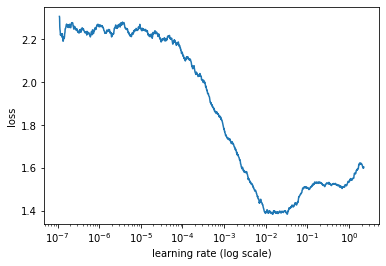

In [ ]:
# find a good learning rate
learner.lr_find()
learner.lr_plot()

In [ ]:
learner.fit_onecycle(1e-3, 4)

In [ ]:
learner.fit_onecycle(3e-4, 4)



begin training using onecycle policy with max lr of 0.0003...
Train on 132067 samples, validate on 14675 samples
Epoch 1/4
132067/132067 [==============================] - 162s 1ms/sample - loss: 1.0737 - accuracy: 0.4851 - val_loss: 1.0510 - val_accuracy: 0.4940
Epoch 2/4
132067/132067 [==============================] - 156s 1ms/sample - loss: 1.0647 - accuracy: 0.4877 - val_loss: 1.0516 - val_accuracy: 0.4891
Epoch 3/4
132067/132067 [==============================] - 155s 1ms/sample - loss: 1.0375 - accuracy: 0.4976 - val_loss: 1.0465 - val_accuracy: 0.4923
Epoch 4/4
132067/132067 [==============================] - 151s 1ms/sample - loss: 1.0078 - accuracy: 0.5114 - val_loss: 1.0474 - val_accuracy: 0.4925


In [ ]:
# predictor = ktrain.get_predictor(learner.model, preproc)
# predictor.save('/content/drive/My Drive/COLAB NOTEBOOKS/SCL/C06/fasttext_cleaned')
predictor = ktrain.load_predictor('/content/drive/My Drive/COLAB NOTEBOOKS/SCL/C06/fasttext_cleaned')

test_df = pd.read_csv('/content/drive/My Drive/COLAB NOTEBOOKS/SCL/C06/test_clean.csv')
test_df.review.fillna("",inplace=True)

In [ ]:
# preds = test_df.review.progress_apply(lambda x: np.argmax(predictor.predict_proba(x)))
probs = test_df.review.progress_apply(lambda x: predictor.predict_proba(x))
np.save('/content/drive/My Drive/COLAB NOTEBOOKS/SCL/C06/fasttext_clean', probs)
preds = probs.apply(lambda x: np.argmax(x))

### continue training

## Extended train set

detected encoding: utf-8 (if wrong, set manually)
language: en
Word Counts: 70211
Nrows: 186452
186452 train sequences
train sequence lengths:
	mean : 15
	95percentile : 38
	99percentile : 54
x_train shape: (186452,150)
y_train shape: (186452, 6)
Is Multi-Label? False
20717 test sequences
test sequence lengths:
	mean : 15
	95percentile : 38
	99percentile : 54
x_test shape: (20717,150)
y_test shape: (20717, 6)
Is Multi-Label? False
compiling word ID features...
maxlen is 150
done.
simulating training for different learning rates... this may take a few moments...
Train on 186452 samples
Epoch 1/1024
 55040/186452 [=======>......................] - ETA: 2:05 - loss: 1.9203 - accuracy: 0.2316

done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


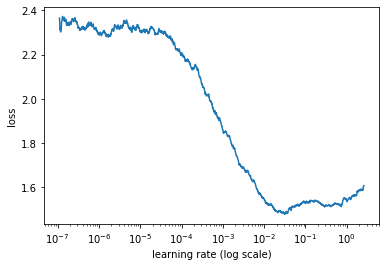

In [ ]:
DATA_PATH = '/content/drive/My Drive/COLAB NOTEBOOKS/SCL/C06/new_train_clean.csv'
NUM_WORDS = 50000
MAXLEN = 150
(x_train, y_train), (x_test, y_test), preproc =  txt.texts_from_csv(DATA_PATH,
                                'review',
                                 label_columns='rating',
                                 val_filepath=None, 
                                 max_features=NUM_WORDS, 
                                 maxlen=150,
                                 ngram_range=1,
                                 random_state=2020, 
                                 val_pct=0.1)
# model = t.get_classifier()
model = txt.text_classifier('fasttext', (x_train, y_train), preproc=preproc)
# learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=6)
learner = ktrain.get_learner(model, train_data=(x_train, y_train),
                                   val_data=(x_test, y_test))
# find a good learning rate
learner.lr_find()
learner.lr_plot()

In [ ]:
learner.fit_onecycle(5e-3, 4)



begin training using onecycle policy with max lr of 0.005...
Train on 186452 samples, validate on 20717 samples
Epoch 1/4
186452/186452 [==============================] - 183s 981us/sample - loss: 1.3322 - accuracy: 0.3829 - val_loss: 1.2788 - val_accuracy: 0.4019
Epoch 2/4
186452/186452 [==============================] - 182s 978us/sample - loss: 1.2982 - accuracy: 0.4014 - val_loss: 1.2769 - val_accuracy: 0.4092
Epoch 3/4
186452/186452 [==============================] - 180s 967us/sample - loss: 1.2721 - accuracy: 0.4128 - val_loss: 1.2522 - val_accuracy: 0.4243
Epoch 4/4
186452/186452 [==============================] - 180s 967us/sample - loss: 1.2259 - accuracy: 0.4342 - val_loss: 1.2486 - val_accuracy: 0.4232


In [ ]:
learner.fit_onecycle(6e-4, 4)



begin training using onecycle policy with max lr of 0.0006...
Train on 186452 samples, validate on 20717 samples
Epoch 1/4
186452/186452 [==============================] - 180s 963us/sample - loss: 1.2020 - accuracy: 0.4442 - val_loss: 1.2502 - val_accuracy: 0.4268
Epoch 2/4
186452/186452 [==============================] - 180s 968us/sample - loss: 1.1992 - accuracy: 0.4461 - val_loss: 1.2499 - val_accuracy: 0.4234
Epoch 3/4
186452/186452 [==============================] - 182s 975us/sample - loss: 1.1916 - accuracy: 0.4477 - val_loss: 1.2512 - val_accuracy: 0.4249
Epoch 4/4
186452/186452 [==============================] - 183s 979us/sample - loss: 1.1829 - accuracy: 0.4521 - val_loss: 1.2524 - val_accuracy: 0.4221


In [ ]:
learner.fit_onecycle(3e-4, 4)



begin training using onecycle policy with max lr of 0.0003...
Train on 186452 samples, validate on 20717 samples
Epoch 1/4
186452/186452 [==============================] - 184s 986us/sample - loss: 1.1809 - accuracy: 0.4540 - val_loss: 1.2528 - val_accuracy: 0.4257
Epoch 2/4
186452/186452 [==============================] - 183s 981us/sample - loss: 1.1795 - accuracy: 0.4530 - val_loss: 1.2553 - val_accuracy: 0.4254
Epoch 3/4
186452/186452 [==============================] - 182s 976us/sample - loss: 1.1778 - accuracy: 0.4541 - val_loss: 1.2554 - val_accuracy: 0.4254
Epoch 4/4
186452/186452 [==============================] - 181s 969us/sample - loss: 1.1717 - accuracy: 0.4582 - val_loss: 1.2560 - val_accuracy: 0.4228


In [ ]:
learner.fit_onecycle(1e-4, 4)



begin training using onecycle policy with max lr of 0.0001...
Train on 186452 samples, validate on 20717 samples
Epoch 1/4
186452/186452 [==============================] - 182s 977us/sample - loss: 1.1692 - accuracy: 0.4582 - val_loss: 1.2565 - val_accuracy: 0.4245
Epoch 2/4
186452/186452 [==============================] - 181s 969us/sample - loss: 1.1692 - accuracy: 0.4589 - val_loss: 1.2564 - val_accuracy: 0.4231
Epoch 3/4
186452/186452 [==============================] - 181s 969us/sample - loss: 1.1689 - accuracy: 0.4586 - val_loss: 1.2569 - val_accuracy: 0.4248
Epoch 4/4
186452/186452 [==============================] - 180s 967us/sample - loss: 1.1684 - accuracy: 0.4597 - val_loss: 1.2570 - val_accuracy: 0.4245


In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc)
predictor.save('/content/drive/My Drive/COLAB NOTEBOOKS/SCL/C06/fasttext_cleaned_extended')
# predictor = ktrain.load_predictor('/content/drive/My Drive/COLAB NOTEBOOKS/SCL/C06/fasttext_cleaned_extended')

test_df = pd.read_csv('/content/drive/My Drive/COLAB NOTEBOOKS/SCL/C06/test_clean_extended.csv')
test_df.review.fillna("",inplace=True)

In [ ]:
# preds = test_df.review.progress_apply(lambda x: np.argmax(predictor.predict_proba(x)))
probs = test_df.review.progress_apply(lambda x: predictor.predict_proba(x))
np.save('/content/drive/My Drive/COLAB NOTEBOOKS/SCL/C06/fasttext_clean_extended', probs)
preds = np.argmax(probs, axis = 1)

In [ ]:
final = pd.DataFrame({'review_id': test_df.review_id, 'rating': preds})
final.to_csv('/content/drive/My Drive/COLAB NOTEBOOKS/SCL/C06/dom_fasttext_cleaned_extended.csv', index=False)


# Fastai

## Defining functions

In [ ]:
def seed_all(seed_value):
    random.seed(seed_value) # Python
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False
class TransformersBaseTokenizer(BaseTokenizer):
    """Wrapper around PreTrainedTokenizer to be compatible with fast.ai"""
    def __init__(self, pretrained_tokenizer: PreTrainedTokenizer, model_type = 'bert', **kwargs):
        self._pretrained_tokenizer = pretrained_tokenizer
        self.max_seq_len = pretrained_tokenizer.max_len
        self.model_type = model_type

    def __call__(self, *args, **kwargs): 
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length and add the spesial tokens"""
        CLS = self._pretrained_tokenizer.cls_token
        SEP = self._pretrained_tokenizer.sep_token
        if self.model_type in ['roberta']:
            tokens = self._pretrained_tokenizer.tokenize(t, add_prefix_space=True)[:self.max_seq_len - 2]
            tokens = [CLS] + tokens + [SEP]
        else:
            tokens = self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2]
            if self.model_type in ['xlnet']:
                tokens = tokens + [SEP] +  [CLS]
            else:
                tokens = [CLS] + tokens + [SEP]
        return tokens
class TransformersVocab(Vocab):
    def __init__(self, tokenizer: PreTrainedTokenizer):
        super(TransformersVocab, self).__init__(itos = [])
        self.tokenizer = tokenizer
    
    def numericalize(self, t:Collection[str]) -> List[int]:
        "Convert a list of tokens `t` to their ids."
        return self.tokenizer.convert_tokens_to_ids(t)
        #return self.tokenizer.encode(t)

    def textify(self, nums:Collection[int], sep=' ') -> List[str]:
        "Convert a list of `nums` to their tokens."
        nums = np.array(nums).tolist()
        return sep.join(self.tokenizer.convert_ids_to_tokens(nums)) if sep is not None else self.tokenizer.convert_ids_to_tokens(nums)
    
    def __getstate__(self):
        return {'itos':self.itos, 'tokenizer':self.tokenizer}

    def __setstate__(self, state:dict):
        self.itos = state['itos']
        self.tokenizer = state['tokenizer']
        self.stoi = collections.defaultdict(int,{v:k for k,v in enumerate(self.itos)})
# defining our model architecture 
class CustomTransformerModel(nn.Module):
    def __init__(self, transformer_model: PreTrainedModel):
        super(CustomTransformerModel,self).__init__()
        self.transformer = transformer_model
        
    def forward(self, input_ids, attention_mask=None):
        
        # attention_mask
        # Mask to avoid performing attention on padding token indices.
        # Mask values selected in ``[0, 1]``:
        # ``1`` for tokens that are NOT MASKED, ``0`` for MASKED tokens.
        attention_mask = (input_ids!=pad_idx).type(input_ids.type()) 
        
        logits = self.transformer(input_ids,
                                  attention_mask = attention_mask)[0]   
        return logits
def get_preds_as_nparray(ds_type) -> np.ndarray:
    """
    the get_preds method does not yield the elements in order by default
    we borrow the code from the RNNLearner to resort the elements into their correct order
    """
    preds = learner.get_preds(ds_type)[0].detach().cpu().numpy()
    sampler = [i for i in databunch.dl(ds_type).sampler]
    reverse_sampler = np.argsort(sampler)
    return preds[reverse_sampler, :]

## Roberta

In [ ]:
MODEL_CLASSES = {
    'bert': (BertForSequenceClassification, BertTokenizer, BertConfig),
    'xlnet': (XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig),
    'xlm': (XLMForSequenceClassification, XLMTokenizer, XLMConfig),
    'roberta': (RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig),
    'distilbert': (DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig)}
# Parameters
seed = 2020
seed_all(seed)

use_fp16 = False
bs = 16

model_type = 'roberta'
pretrained_model_name = 'roberta-base'

# model_type = 'bert'
# pretrained_model_name='bert-base-uncased'

# model_type = 'distilbert'
# pretrained_model_name = 'distilbert-base-uncased'

#model_type = 'xlm'
#pretrained_model_name = 'xlm-clm-enfr-1024'

# model_type = 'xlnet'
# pretrained_model_name = 'xlnet-base-cased'
model_class, tokenizer_class, config_class = MODEL_CLASSES[model_type]

In [ ]:
transformer_tokenizer = tokenizer_class.from_pretrained(pretrained_model_name)
transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer = transformer_tokenizer, model_type = model_type)
fastai_tokenizer = Tokenizer(tok_func = transformer_base_tokenizer, pre_rules=[], post_rules=[])
transformer_vocab =  TransformersVocab(tokenizer = transformer_tokenizer)
numericalize_processor = NumericalizeProcessor(vocab=transformer_vocab)

tokenize_processor = TokenizeProcessor(tokenizer=fastai_tokenizer, include_bos=False, include_eos=False)

transformer_processor = [tokenize_processor, numericalize_processor]
pad_first = bool(model_type in ['xlnet'])
pad_idx = transformer_tokenizer.pad_token_id
config = config_class.from_pretrained(pretrained_model_name)
config.num_labels = 5
config.use_bfloat16 = use_fp16
# print(config)
transformer_model = model_class.from_pretrained(pretrained_model_name, config = config)
# transformer_model = model_class.from_pretrained(pretrained_model_name, num_labels = 5)

custom_transformer_model = CustomTransformerModel(transformer_model = transformer_model)

# print('[CLS] token :', transformer_tokenizer.cls_token)
# print('[SEP] token :', transformer_tokenizer.sep_token)
# print('[PAD] token :', transformer_tokenizer.pad_token)
# databunch.show_batch()

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out

In [ ]:
# RUN model configurations first
path = '/content/drive/My Drive/COLAB NOTEBOOKS/SCL/C06/'
train = pd.read_csv(path + 'train_clean.csv')
test = pd.read_csv(path + 'test_clean.csv')
train.fillna('',inplace=True)
test.fillna('',inplace=True)

databunch = (TextList.from_df(train, cols='review', processor=transformer_processor)
             .split_by_rand_pct(0.1,seed=seed)
             .label_from_df(cols= 'rating')
             .add_test(test)
             .databunch(bs=bs, pad_first=pad_first, pad_idx=pad_idx))

In [ ]:
from fastai.callbacks import *
from transformers import AdamW
from functools import partial

CustomAdamW = partial(AdamW, correct_bias=False)

learner = Learner(databunch, 
                  custom_transformer_model, 
                  opt_func = CustomAdamW, 
                  metrics=[accuracy, error_rate])

# Show graph of learner stats and metrics after each epoch.
learner.callbacks.append(ShowGraph(learner))

# Put learn in FP16 precision mode. --> Seems to not working
if use_fp16: learner = learner.to_fp16()
# For DistilBERT
# list_layers = [learner.model.transformer.distilbert.embeddings,
#                learner.model.transformer.distilbert.transformer.layer[0],
#                learner.model.transformer.distilbert.transformer.layer[1],
#                learner.model.transformer.distilbert.transformer.layer[2],
#                learner.model.transformer.distilbert.transformer.layer[3],
#                learner.model.transformer.distilbert.transformer.layer[4],
#                learner.model.transformer.distilbert.transformer.layer[5],
#                learner.model.transformer.pre_classifier]

# For xlnet-base-cased
# list_layers = [learner.model.transformer.transformer.word_embedding,
#               learner.model.transformer.transformer.layer[0],
#               learner.model.transformer.transformer.layer[1],
#               learner.model.transformer.transformer.layer[2],
#               learner.model.transformer.transformer.layer[3],
#               learner.model.transformer.transformer.layer[4],
#               learner.model.transformer.transformer.layer[5],
#               learner.model.transformer.transformer.layer[6],
#               learner.model.transformer.transformer.layer[7],
#               learner.model.transformer.transformer.layer[8],
#               learner.model.transformer.transformer.layer[9],
#               learner.model.transformer.transformer.layer[10],
#               learner.model.transformer.transformer.layer[11],
#               learner.model.transformer.sequence_summary]

# For roberta-base
list_layers = [learner.model.transformer.roberta.embeddings,
              learner.model.transformer.roberta.encoder.layer[0],
              learner.model.transformer.roberta.encoder.layer[1],
              learner.model.transformer.roberta.encoder.layer[2],
              learner.model.transformer.roberta.encoder.layer[3],
              learner.model.transformer.roberta.encoder.layer[4],
              learner.model.transformer.roberta.encoder.layer[5],
              learner.model.transformer.roberta.encoder.layer[6],
              learner.model.transformer.roberta.encoder.layer[7],
              learner.model.transformer.roberta.encoder.layer[8],
              learner.model.transformer.roberta.encoder.layer[9],
              learner.model.transformer.roberta.encoder.layer[10],
              learner.model.transformer.roberta.encoder.layer[11],
              learner.model.transformer.roberta.pooler]
learner.split(list_layers)
num_groups = len(learner.layer_groups)
print('Learner split in',num_groups,'groups')
# print(learner.layer_groups)

In [ ]:
learner.save('untrain')

In [ ]:
seed_all(seed)
learner.load('untrain');

In [ ]:
learner.freeze_to(-1)
# learner.summary()

epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.79E-04
Min loss divided by 10: 1.91E-05


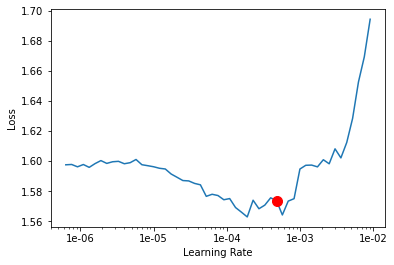

In [ ]:
learner.lr_find()
learner.recorder.plot(skip_end=10,suggestion=True)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.306971,1.250487,0.417337,0.582663,04:35


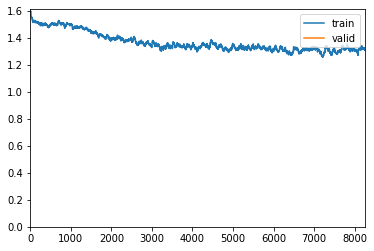

In [ ]:
learner.fit_one_cycle(1,max_lr=2e-04,moms=(0.8,0.7))
learner.save('first_cycle')
seed_all(seed)
learner.load('first_cycle');
learner.freeze_to(-2)
lr = 1e-5
learner.fit_one_cycle(1, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))
learner.save('second_cycle')
seed_all(seed)
learner.load('second_cycle');
learner.freeze_to(-3)
learner.fit_one_cycle(1, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))
learner.save('third_cycle')
seed_all(seed)
learner.load('third_cycle');

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.042219,1.032762,0.498910,0.501090,17:41
1,0.997515,0.984654,0.512471,0.487529,17:26


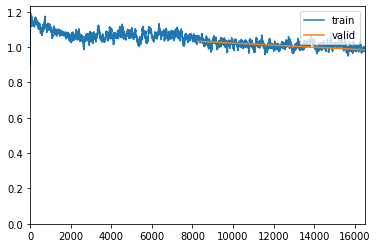

In [ ]:
learner.unfreeze()
learner.fit_one_cycle(2, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.010454,0.987338,0.507087,0.492913,16:45
1,0.938736,0.983555,0.518264,0.481736,17:19


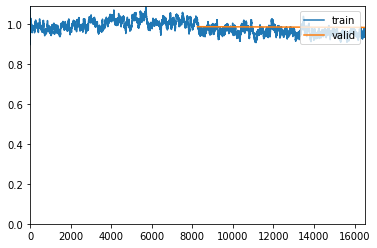

In [ ]:
learner.fit_one_cycle(2, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

In [ ]:
# learner.export(file='roberta');
# export_learner = load_learner(path, file = 'roberta.pkl')

In [ ]:
test_preds = get_preds_as_nparray(DatasetType.Test)
final = pd.DataFrame({'review_id': test.review_id, 'rating': np.argmax(test_preds,axis=1) + 1})
final.to_csv('/content/drive/My Drive/COLAB NOTEBOOKS/SCL/C06/dom_roberta_clean.csv', index=False)
np.save(os.path.join(path, 'roberta_preds'), test_preds)

## XLNet

In [ ]:
MODEL_CLASSES = {
    'bert': (BertForSequenceClassification, BertTokenizer, BertConfig),
    'xlnet': (XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig),
    'xlm': (XLMForSequenceClassification, XLMTokenizer, XLMConfig),
    'roberta': (RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig),
    'distilbert': (DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig)}
# Parameters
seed = 2020
seed_all(seed)

use_fp16 = False
bs = 16

# model_type = 'roberta'
# pretrained_model_name = 'roberta-base'

# model_type = 'bert'
# pretrained_model_name='bert-base-uncased'

# model_type = 'distilbert'
# pretrained_model_name = 'distilbert-base-uncased'

#model_type = 'xlm'
#pretrained_model_name = 'xlm-clm-enfr-1024'

model_type = 'xlnet'
pretrained_model_name = 'xlnet-base-cased'

model_class, tokenizer_class, config_class = MODEL_CLASSES[model_type]

In [ ]:
transformer_tokenizer = tokenizer_class.from_pretrained(pretrained_model_name)
transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer = transformer_tokenizer, model_type = model_type)
fastai_tokenizer = Tokenizer(tok_func = transformer_base_tokenizer, pre_rules=[], post_rules=[])
transformer_vocab =  TransformersVocab(tokenizer = transformer_tokenizer)
numericalize_processor = NumericalizeProcessor(vocab=transformer_vocab)

tokenize_processor = TokenizeProcessor(tokenizer=fastai_tokenizer, include_bos=False, include_eos=False)

transformer_processor = [tokenize_processor, numericalize_processor]
pad_first = bool(model_type in ['xlnet'])
pad_idx = transformer_tokenizer.pad_token_id
config = config_class.from_pretrained(pretrained_model_name)
config.num_labels = 5
config.use_bfloat16 = use_fp16
# print(config)
transformer_model = model_class.from_pretrained(pretrained_model_name, config = config)
# transformer_model = model_class.from_pretrained(pretrained_model_name, num_labels = 5)

custom_transformer_model = CustomTransformerModel(transformer_model = transformer_model)

# print('[CLS] token :', transformer_tokenizer.cls_token)
# print('[SEP] token :', transformer_tokenizer.sep_token)
# print('[PAD] token :', transformer_tokenizer.pad_token)
# databunch.show_batch()

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.weight', 'sequence_summary.summary.bias', 'logits_proj.weight', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

In [ ]:
# RUN model configurations first
path = '/content/drive/My Drive/COLAB NOTEBOOKS/SCL/C06/'
train = pd.read_csv(path + 'train_clean.csv')
test = pd.read_csv(path + 'test_clean.csv')
train.fillna('',inplace=True)
test.fillna('',inplace=True)

databunch = (TextList.from_df(train, cols='review', processor=transformer_processor)
             .split_by_rand_pct(0.1,seed=seed)
             .label_from_df(cols= 'rating')
             .add_test(test)
             .databunch(bs=bs, pad_first=pad_first, pad_idx=pad_idx))

In [ ]:
from fastai.callbacks import *
from transformers import AdamW
from functools import partial

CustomAdamW = partial(AdamW, correct_bias=False)

learner = Learner(databunch, 
                  custom_transformer_model, 
                  opt_func = CustomAdamW, 
                  metrics=[accuracy, error_rate])

# Show graph of learner stats and metrics after each epoch.
learner.callbacks.append(ShowGraph(learner))

# Put learn in FP16 precision mode. --> Seems to not working
if use_fp16: learner = learner.to_fp16()

# For DistilBERT
# list_layers = [learner.model.transformer.distilbert.embeddings,
#                learner.model.transformer.distilbert.transformer.layer[0],
#                learner.model.transformer.distilbert.transformer.layer[1],
#                learner.model.transformer.distilbert.transformer.layer[2],
#                learner.model.transformer.distilbert.transformer.layer[3],
#                learner.model.transformer.distilbert.transformer.layer[4],
#                learner.model.transformer.distilbert.transformer.layer[5],
#                learner.model.transformer.pre_classifier]

# For xlnet-base-cased
list_layers = [learner.model.transformer.transformer.word_embedding,
              learner.model.transformer.transformer.layer[0],
              learner.model.transformer.transformer.layer[1],
              learner.model.transformer.transformer.layer[2],
              learner.model.transformer.transformer.layer[3],
              learner.model.transformer.transformer.layer[4],
              learner.model.transformer.transformer.layer[5],
              learner.model.transformer.transformer.layer[6],
              learner.model.transformer.transformer.layer[7],
              learner.model.transformer.transformer.layer[8],
              learner.model.transformer.transformer.layer[9],
              learner.model.transformer.transformer.layer[10],
              learner.model.transformer.transformer.layer[11],
              learner.model.transformer.sequence_summary]

# # For roberta-base
# list_layers = [learner.model.transformer.roberta.embeddings,
#               learner.model.transformer.roberta.encoder.layer[0],
#               learner.model.transformer.roberta.encoder.layer[1],
#               learner.model.transformer.roberta.encoder.layer[2],
#               learner.model.transformer.roberta.encoder.layer[3],
#               learner.model.transformer.roberta.encoder.layer[4],
#               learner.model.transformer.roberta.encoder.layer[5],
#               learner.model.transformer.roberta.encoder.layer[6],
#               learner.model.transformer.roberta.encoder.layer[7],
#               learner.model.transformer.roberta.encoder.layer[8],
#               learner.model.transformer.roberta.encoder.layer[9],
#               learner.model.transformer.roberta.encoder.layer[10],
#               learner.model.transformer.roberta.encoder.layer[11],
#               learner.model.transformer.roberta.pooler]

learner.split(list_layers)
num_groups = len(learner.layer_groups)
print('Learner split in',num_groups,'groups')
# print(learner.layer_groups)

Learner split in 14 groups


epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.75E-06
Min loss divided by 10: 4.79E-05


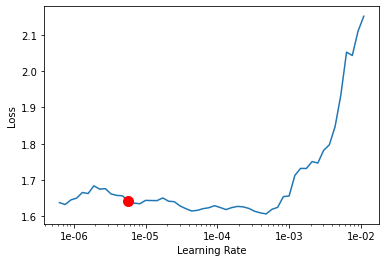

In [ ]:
learner.freeze_to(-1)
# learner.summary()
learner.lr_find()
learner.recorder.plot(skip_end=10,suggestion=True)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.384519,1.313936,0.373586,0.626414,11:42


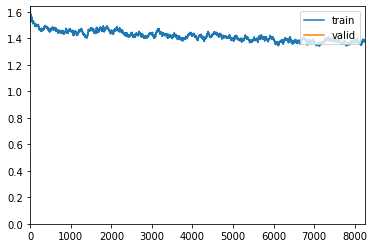

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.257111,1.179369,0.435191,0.564808,14:37


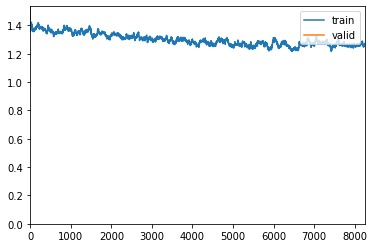

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.208454,1.137917,0.456249,0.543751,17:06


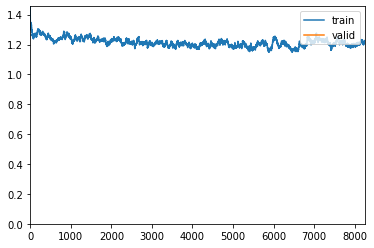

In [ ]:
learner.fit_one_cycle(1,max_lr=3e-04,moms=(0.8,0.7))
learner.save('first_cycle')
seed_all(seed)
learner.load('first_cycle');
learner.freeze_to(-2)
lr = 8e-06
learner.fit_one_cycle(1, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))
learner.save('second_cycle')
seed_all(seed)
learner.load('second_cycle');
learner.freeze_to(-3)
learner.fit_one_cycle(1, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))
learner.save('third_cycle')
seed_all(seed)
learner.load('third_cycle');

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.081935,1.062732,0.486166,0.513834,40:11
1,1.060990,1.025500,0.493594,0.506406,39:18
2,0.973917,1.010844,0.503339,0.496661,40:37
3,0.962404,1.010978,0.499932,0.500068,40:12


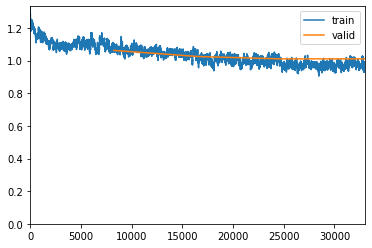

In [ ]:
learner.unfreeze()
learner.fit_one_cycle(4, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

In [ ]:
learner.export(path, file = 'xlnet.pkl');
export_learner = load_learner(path, file = 'xlnet.pkl')

In [ ]:
test_preds = get_preds_as_nparray(DatasetType.Test)
final = pd.DataFrame({'review_id': test.review_id, 'rating': np.argmax(test_preds,axis=1)+1})
final.to_csv('/content/drive/My Drive/COLAB NOTEBOOKS/SCL/C06/dom_xlnet_clean.csv', index=False)
np.save(os.path.join(path, 'xlnet_preds'), test_preds)

## Tuning Roberta

In [ ]:
MODEL_CLASSES = {
    'bert': (BertForSequenceClassification, BertTokenizer, BertConfig),
    'xlnet': (XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig),
    'xlm': (XLMForSequenceClassification, XLMTokenizer, XLMConfig),
    'roberta': (RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig),
    'distilbert': (DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig)}
# Parameters
seed = 2020
seed_all(seed)

use_fp16 = False
bs = 16

model_type = 'roberta'
pretrained_model_name = 'roberta-base'

# model_type = 'bert'
# pretrained_model_name='bert-base-uncased'

# model_type = 'distilbert'
# pretrained_model_name = 'distilbert-base-uncased'

#model_type = 'xlm'
#pretrained_model_name = 'xlm-clm-enfr-1024'

# model_type = 'xlnet'
# pretrained_model_name = 'xlnet-base-cased'
model_class, tokenizer_class, config_class = MODEL_CLASSES[model_type]

In [ ]:
transformer_tokenizer = tokenizer_class.from_pretrained(pretrained_model_name)
transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer = transformer_tokenizer, model_type = model_type)
fastai_tokenizer = Tokenizer(tok_func = transformer_base_tokenizer, pre_rules=[], post_rules=[])
transformer_vocab =  TransformersVocab(tokenizer = transformer_tokenizer)
numericalize_processor = NumericalizeProcessor(vocab=transformer_vocab)

tokenize_processor = TokenizeProcessor(tokenizer=fastai_tokenizer, include_bos=False, include_eos=False)

transformer_processor = [tokenize_processor, numericalize_processor]
pad_first = bool(model_type in ['xlnet'])
pad_idx = transformer_tokenizer.pad_token_id
config = config_class.from_pretrained(pretrained_model_name)
config.num_labels = 5
config.use_bfloat16 = use_fp16
# print(config)
transformer_model = model_class.from_pretrained(pretrained_model_name, config = config)
# transformer_model = model_class.from_pretrained(pretrained_model_name, num_labels = 5)

custom_transformer_model = CustomTransformerModel(transformer_model = transformer_model)

# print('[CLS] token :', transformer_tokenizer.cls_token)
# print('[SEP] token :', transformer_tokenizer.sep_token)
# print('[PAD] token :', transformer_tokenizer.pad_token)
# databunch.show_batch()

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out

In [ ]:
# RUN model configurations first
path = '/content/drive/My Drive/COLAB NOTEBOOKS/SCL/C06/'
train = pd.read_csv(path + 'train_clean.csv')
test = pd.read_csv(path + 'test_clean.csv')
train.fillna('',inplace=True)
test.fillna('',inplace=True)

databunch = (TextList.from_df(train, cols='review', processor=transformer_processor)
             .split_by_rand_pct(0.1,seed=seed)
             .label_from_df(cols= 'rating')
             .add_test(test)
             .databunch(bs=bs, pad_first=pad_first, pad_idx=pad_idx))

In [ ]:
from fastai.callbacks import *
from transformers import AdamW
from functools import partial

# CustomAdamW = partial(AdamW, correct_bias=False)

learner = Learner(databunch, 
                  custom_transformer_model, 
                  # opt_func = CustomAdamW, 
                  metrics=[accuracy])

# Show graph of learner stats and metrics after each epoch.
learner.callbacks.append(ShowGraph(learner))

# Put learn in FP16 precision mode. --> Seems to not working
if use_fp16: learner = learner.to_fp16()
# For DistilBERT
# list_layers = [learner.model.transformer.distilbert.embeddings,
#                learner.model.transformer.distilbert.transformer.layer[0],
#                learner.model.transformer.distilbert.transformer.layer[1],
#                learner.model.transformer.distilbert.transformer.layer[2],
#                learner.model.transformer.distilbert.transformer.layer[3],
#                learner.model.transformer.distilbert.transformer.layer[4],
#                learner.model.transformer.distilbert.transformer.layer[5],
#                learner.model.transformer.pre_classifier]

# For xlnet-base-cased
# list_layers = [learner.model.transformer.transformer.word_embedding,
#               learner.model.transformer.transformer.layer[0],
#               learner.model.transformer.transformer.layer[1],
#               learner.model.transformer.transformer.layer[2],
#               learner.model.transformer.transformer.layer[3],
#               learner.model.transformer.transformer.layer[4],
#               learner.model.transformer.transformer.layer[5],
#               learner.model.transformer.transformer.layer[6],
#               learner.model.transformer.transformer.layer[7],
#               learner.model.transformer.transformer.layer[8],
#               learner.model.transformer.transformer.layer[9],
#               learner.model.transformer.transformer.layer[10],
#               learner.model.transformer.transformer.layer[11],
#               learner.model.transformer.sequence_summary]

# For roberta-base
list_layers = [learner.model.transformer.roberta.embeddings,
              learner.model.transformer.roberta.encoder.layer[0],
              learner.model.transformer.roberta.encoder.layer[1],
              learner.model.transformer.roberta.encoder.layer[2],
              learner.model.transformer.roberta.encoder.layer[3],
              learner.model.transformer.roberta.encoder.layer[4],
              learner.model.transformer.roberta.encoder.layer[5],
              learner.model.transformer.roberta.encoder.layer[6],
              learner.model.transformer.roberta.encoder.layer[7],
              learner.model.transformer.roberta.encoder.layer[8],
              learner.model.transformer.roberta.encoder.layer[9],
              learner.model.transformer.roberta.encoder.layer[10],
              learner.model.transformer.roberta.encoder.layer[11],
              learner.model.transformer.roberta.pooler]
learner.split(list_layers)
num_groups = len(learner.layer_groups)
print('Learner split in',num_groups,'groups')
# print(learner.layer_groups)

Learner split in 14 groups


In [ ]:
learner.save('untrain')
learner.load('untrain');

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.75E-04
Min loss divided by 10: 1.20E-04


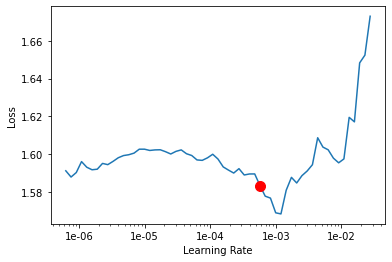

In [ ]:
seed_all(seed)
learner.freeze_to(-1)
# learner.summary()
learner.lr_find()
learner.recorder.plot(skip_end=10,suggestion=True)

epoch,train_loss,valid_loss,accuracy,time
0,1.260259,1.195097,0.440303,05:42


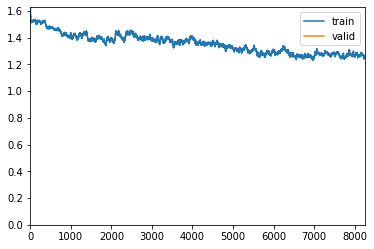

epoch,train_loss,valid_loss,accuracy,time
0,1.103659,1.075476,0.479351,06:59


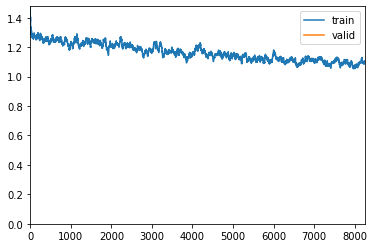

epoch,train_loss,valid_loss,accuracy,time
0,1.089587,1.073334,0.481873,08:23


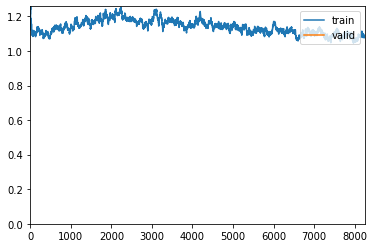

In [ ]:
learner.fit_one_cycle(1,max_lr=3e-03,moms=(0.8,0.7))
learner.save('first_cycle')
seed_all(seed)
learner.load('first_cycle');
learner.freeze_to(-2)
lr = 3e-4
learner.fit_one_cycle(1, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))
learner.save('second_cycle')
seed_all(seed)
learner.load('second_cycle');
learner.freeze_to(-3)
learner.fit_one_cycle(1, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))
learner.save('third_cycle')
seed_all(seed)
learner.load('third_cycle');

epoch,train_loss,valid_loss,accuracy,time
0,1.521588,1.506864,0.282609,26:11


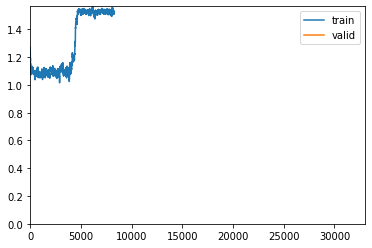

In [ ]:
learner.unfreeze()
learner.fit_one_cycle(4, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.010454,0.987338,0.507087,0.492913,16:45
1,0.938736,0.983555,0.518264,0.481736,17:19


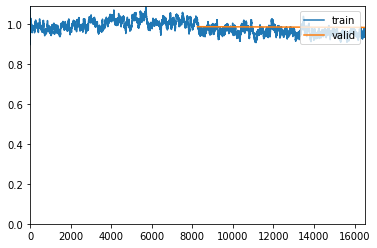

In [ ]:
learner.fit_one_cycle(2, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

In [ ]:
# learner.export(file='roberta');
# export_learner = load_learner(path, file = 'roberta.pkl')

In [ ]:
test_preds = get_preds_as_nparray(DatasetType.Test)
final = pd.DataFrame({'review_id': test.review_id, 'rating': np.argmax(test_preds,axis=1) + 1})
final.to_csv('/content/drive/My Drive/COLAB NOTEBOOKS/SCL/C06/dom_roberta_clean.csv', index=False)
np.save(os.path.join(path, 'roberta_preds'), test_preds)

## Ensembling


In [ ]:
path = '/content/drive/My Drive/COLAB NOTEBOOKS/SCL/C06/'
fasttext = np.load(path+'fasttext_clean.npy', allow_pickle=True)
roberta = np.load(path+'roberta_preds.npy', allow_pickle=True)
xlnet = np.load(path+'xlnet_preds.npy', allow_pickle=True)

In [ ]:
for i in range(len(fasttext)):
  fasttext[i] = fasttext[i][1:]

temp = np.zeros(shape=(60427,5))
for i in range(len(fasttext)):
  temp[i] = fasttext[i]

fasttext = temp

In [ ]:
ensem_preds = (fasttext + roberta + xlnet)/3

In [ ]:
preds = np.argmax(ensem_preds, axis=1) + 1

In [ ]:
for i in range(1,6):
  print(i, np.count_nonzero(preds == i))

1 5367
2 788
3 13185
4 32994
5 8093


In [ ]:
final = pd.DataFrame({'review_id': test.review_id, 'rating': preds})
final.to_csv(path + 'dom_ensem_clean.csv', index=False)